# Bayesian Statistics


## Motivation - distances to stars

Let's start by imagining that we have a method to measure the distance to a star. As with all observations, there is some uncertainty associated with that measurement. So let's imagine that our particular star is at a distance of 100 pc, and our measurement method allows us a precision of 20 pc. If we were to measure the same star 10,000 separate times, we would find that half the time the star is _observed_ to be nearer than 100 pc, and the other half it is _observed_ to be farther than 100 pc. In fact, the distance distribution will form (by definition) a Gaussian, centered on 100 pc, with a standard deviation of 20 pc.

Now, instead of a single star, let's imagine that we have a population of 10,000 stars spread out evenly within the nearest 100 pc. Do we still find that half of all stars are closer than they appear and half are further than they appear? Let's investigate. 

So, let's imagine that we observe the parallaxes to 1000 stars, with an angular precision of 2 mas (10$^3$ mas = 1 arcsecond). Let's further assume the stars are evenly distributed within the nearest 100 pc. First, we'll generate the actual distances to those stars.

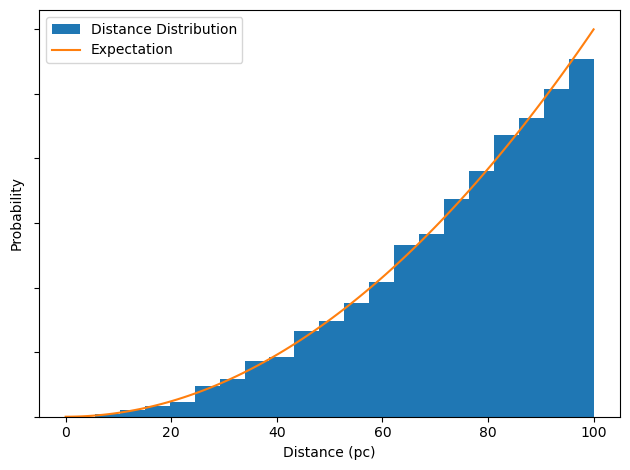

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


N_stars = 10000

# Generate random distances within nearest 100 pc
distance = 100.0*np.random.rand(N_stars)**(1.0/3.0)

# Plot histogram of distances
plt.hist(distance, bins=20, density=True, label='Distance Distribution')

# Plot expectation from a constant stellar density sphere
tmp_x = np.linspace(0, 100, 100)
plt.plot(tmp_x, (tmp_x)**2*3.0/100.0**3, label='Expectation')


# Add plot legend
plt.legend()

# Make plot pretty
plt.gca().set_yticklabels([])

plt.xlabel('Distance (pc)')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

### In two minutes, discuss with your partner why the distribution rises as r$^2$

Answer is hidden here

[//]: # (The volume of an infinitely thin shell is r^2 dr, As r increases, the volume scales with r^2)

## Now, let's add measurement uncertainties to our observations

Practically, this amounts to just adding to the actual distance a random number drawn from a Gaussian distribution centered on zero, with a standard deviation of 20 pc. We show the results below.

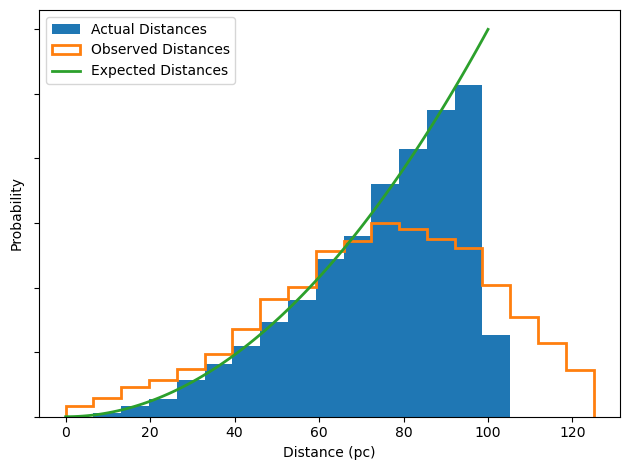

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

bins = np.linspace(0, 125, 20)

# Generate mock observations
observed_distance = distance + np.random.normal(0, 20.0, size=len(distance))

# Plot histogram of distances and observed distances
plt.hist(distance, bins=bins, density=True, label='Actual Distances')
plt.hist(observed_distance, bins=bins, density=True, label='Observed Distances', histtype='step', linewidth=2)

# Plot expectation from a constant stellar density sphere
tmp_x = np.linspace(0, 100, 100)
plt.plot(tmp_x, (tmp_x)**2*3.0/100.0**3, label='Expected Distances', linewidth=2)


# Add plot legend
plt.legend()

# Make plot pretty
plt.gca().set_yticklabels([])

plt.xlabel('Distance (pc)')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

Now, let's convert the observed parallaxes back to distances.

The most obvious difference here is that some distances appear significantly larger than they actually are. But there's a second, more insidious difference between the two distributions. 

Let's just focus on stars with _apparent_ distances between 70 and 80 pc. Within this distance, I want to compare the number of stars that have apparent distances smaller than their true distances with the number that have larger apparent distances.

In [3]:
# We start by finding the indices of the array values within 5 pc of 75 pc
idx = np.where(np.abs(observed_distance-75.0) < 5.0)[0]

num_lower = len(np.where(observed_distance[idx] < distance[idx])[0])
num_higher = len(np.where(observed_distance[idx] > distance[idx])[0])

print(num_lower, "stars are further than they appear.")
print(num_higher, "stars are closer than they appear.")

869 stars are further than they appear.
548 stars are closer than they appear.


We see that most stars have actual distances larger than the apparent distance, by a large majority. This is very strange. Why is it that when I previously measured my star 10,000 times. I found that half the time it appeared closer than its true distance, while when I measure 10,000 separate stars only about a third of the time does the star appear closer than its true distance?

You can rerun the above blocks several times to convince yourself that this is not just stochastic, random noise. Rather, this is a bias: the actual distance is systematically larger than the observed distance. This bias is called the Lutz-Kelker bias, after the two authors of the paper that first described this bias (https://ui.adsabs.harvard.edu/abs/1973PASP...85..573L/abstract).



### With your partner discuss the possible origin of this bias

Answer is hidden here

[//]: # (This bias arises from the fact that we have placed stars in the nearby volume with a constant density. Consider one bin in a histogram of stellar distances. Because of the r^2 scaling of stars with distance, there are more stars in the adjacent bin with a slightly larger distance than in the bin with the smaller distance. More stars will "scatter" from larger distances to smaller distances than the opposite, simply because more stars exist at larger distances. )

# Bayesian statistics - distance example

The easiest way to deal with the Lutz-Kelker bias is by using Bayesian statistics. Let's start by applying the (in)famous Bayes's Theorem to the distance probability:

$$ P(r | r_{\rm obs}) = \frac{1}{\mathcal{Z}} P(r_{\rm obs} | r) P(r). $$

Let's go through this Equation. A term $P(A|B)$, is read as "the probability of A given B." In our case, we are interested in the actual distance to a star $r$ given our observed distance $r_{\rm obs}$. We cannot directly calculate this. Instead, we need to calculate a few things on the right hand side of the equation to get there.

First, $\mathcal{Z}$ is a normalization constant, also called the "evidence." For most circumstances, this term can be ignored as it is usually a constant. 

Second, we have a term $P(r_{\rm obs} | r)$, which is known as the likelihood. Using the left-hand-side as analogy, we can interpret this as the probability of observing a star at a distance $r_{\rm obs}$ given its actual distance $r$. Based on our observational precision, this term is a Gaussian: 

$$ P(r_{\rm obs} | r) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left[ - \frac{\left( r - r_{\rm obs} \right)^2}{2 \sigma^2} \right] $$

Finally, we have the term $P(r)$, known as a prior probability. In many cases, the prior is "flat" (which means that it does not scale with $r$) in which case, the posterior probability scales with the likelihood. However, for distances, we unconsciously applied a prior: we are looking into a sphere with a constant stellar density. In this case, the underlying distribution should scale with $r^2$, which produces a very strong prior:

$$ P(r) \sim r^2 $$

This must be normalized. Obviously we cannot observe stars at an infinite distance, and doing so would cause the prior to diverge. We must impose, somewhat artificially, a maximum distance, $r_{\rm max}$, to calculate the normalization constant. Our prior becomes:

$$ P(r) = \cases{ \begin{align} 3 \frac{r^2}{r_{\rm max}^3} & : 0 < r < r_{\rm max}\ \\ 0 & : {\rm else} \end{align}} $$

Combining these terms together, we arrive at the posterior probability for our problem at hand:

$$ P(r | r_{\rm obs}) = \frac{3}{2} \frac{1}{\mathcal{Z}} \frac{r^2}{ r_{\rm max}^3 \sqrt{2 \pi \sigma^2} } \exp\left[ - \frac{\left( r - r_{\rm obs} \right)^2}{2 \sigma^2} \right], $$

for $0<r<r_{\rm max}$.



### Let's see the difference added when the prior is included

Let's say we observe a star at a distance of 90$\pm$20 pc. We want to know what the actual distance to that star is. We will compare the Gaussian expectation (likelihood) with the full posterior distribution, which includes the prior probability.

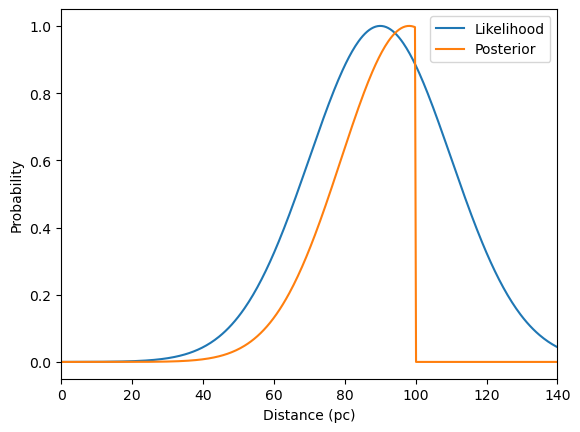

In [4]:
def calc_likelihood(r, r_obs, sigma):
    """ This is just a Gaussian distribution, as discussed above """
    
    return 1.0/np.sqrt(2.0*np.pi*sigma**2) * np.exp( - (r-r_obs)**2/(2.0*sigma**2) )


def calc_prior(r, r_max):
    """ Calculate the prior on r """
    
    prior_r = 3.0 * r**2 / r_max**3  # Our prior from above
    prior_r[r<0] = 0.0  # We cannot have negative distances
    prior_r[r>r_max] = 0.0  # Stars cannot be (by assumption) farther than 100 pc away
    
    return prior_r


def calc_posterior(r, r_obs, sigma, r_max):
    """ Calculate the posterior probability, from the product of the prior probability and likelihood """
    
    return calc_prior(r, r_max) * calc_likelihood(r, r_obs, sigma)



# Our observations
r_obs = 90.0  # Observed distance
sigma = 20.0  # Measurement precision
r_max = 100.0  # Maximum distance of the distribution

# Dummy array for testing different distances
tmp_r = np.linspace(0, 150, 500)

# Call the functions to calculate the likelihood and posterior
likelihood = calc_likelihood(tmp_r, r_obs, sigma)
posterior = calc_posterior(tmp_r, r_obs, sigma, r_max)

# Multiply both distributions by constant such that the maximum value is 1
likelihood /= np.max(likelihood)
posterior /= np.max(posterior)

# Separately plot the likelihood and posterior
plt.plot(tmp_r, likelihood, label='Likelihood')
plt.plot(tmp_r, posterior, label='Posterior')


# Make the plot pretty
plt.xlabel('Distance (pc)')
plt.ylabel('Probability')

plt.legend(loc=1)

plt.xlim(0, 140)

plt.show()

### Spend 5 minutes with your partner experimenting with different values of $r_{\rm obs}$, $r_{\rm max}$, and $\sigma$ in the code block above. Make sure you understand why the distribution behaves in the way it does. Is the likelihood always symmetrically distributed around $r_{\rm obs}$? Is the posterior distribution?

# How do we measure distances to stars?

## Parallaxes

Astrometric parallax is perhaps the most accurate method of measuring the distances to stars. It is essentially model dependent, relying on geometry only. The image below demonstrates how it works. By observing the same star at different times of the year, one can determine the star's distance from how much it moves on the sky. Fun fact: a parsec is defined as the distance a star is to cause a shift in the parallax of 1 arcsecond.

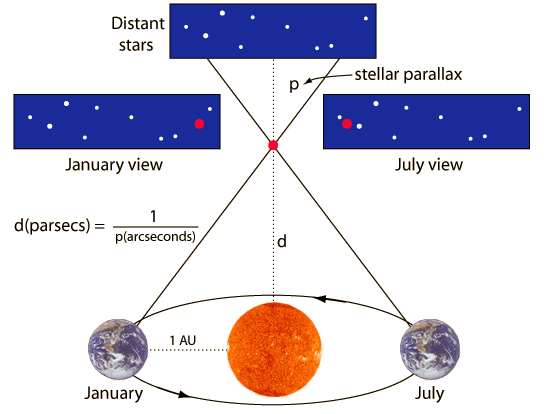

In [5]:
from IPython.display import Image
Image(data = 'images/parallax.gif', width=500)

It's easy to convert distances ($r$) to parallaxes ($\varpi$):

$$ \varpi = \frac{1}{r} $$

You just need to be careful about your units. Knowing that 1 arcsecond corresponds to 1 pc can help.

Rather than measure the distance, astrometric observations seek to measure the parallax. So, our uncertainty will be measured as an angle, rather than a distance. Let's say we may measure the astrometric parallax for a star of 10$\pm$2 mas. We know that implies a distance of 100 pc, but what is the posterior probability distribution of distances to the star? Let's start with Bayes's Theorem. We want to express this in terms of our observable, $\varpi$, and our measurement uncertainty on the parallax, $\sigma_{\varpi}$:

$$ P(r | \varpi_{\rm obs}) = \frac{1}{\mathcal{Z}} P(\varpi_{\rm obs} | r) P(r). $$

We only have a slight difference in our likelihood, since everything is now expressed in terms of the parallax:

$$ P(\varpi_{\rm obs} | r) = \frac{1}{\sqrt{2 \pi \sigma_{\varpi}^2}} \exp\left[ - \frac{\left( 1/r - \varpi_{\rm obs} \right)^2}{2 \sigma_{\varpi}^2} \right]. $$

We can write the new likelihood and posterior probability functions below. The prior has not changed.

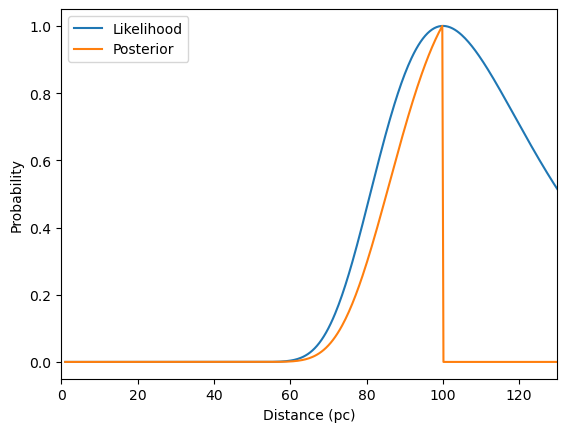

In [6]:
def calc_likelihood_parallax(r, parallax_obs, sigma_parallax):
    """ This is just a Gaussian distribution, as discussed above """
    
    return 1.0/np.sqrt(2.0*np.pi*sigma_parallax**2) * np.exp( - (1.0/r-parallax_obs)**2/(2.0*sigma_parallax**2) )


def calc_prior(r, r_max):
    """ Calculate the prior on r """
    
    prior_r = 3.0 * r**2 / r_max**3  # Our prior from above
    prior_r[r<0] = 0.0  # We cannot have negative distances
    prior_r[r>r_max] = 0.0  # Stars cannot be (by assumption) farther than 100 pc away
    
    return prior_r


def calc_posterior_parallax(r, parallax_obs, sigma_parallax, r_max):
    """ Calculate the posterior probability, from the product of the prior probability and likelihood """
        
    return calc_prior(r, r_max) * calc_likelihood_parallax(r, parallax_obs, sigma_parallax)





# Our observations
parallax_obs = 10.0*1.0e-3  # Observed distance
sigma_parallax = 2.0*1.0e-3  # Measurement precision
r_max = 100.0  # Maximum distance of the distribution

# Dummy array for testing different distances
tmp_r = np.linspace(1.0, 150, 500)

# Call the functions to calculate the likelihood and posterior
likelihood = calc_likelihood_parallax(tmp_r, parallax_obs, sigma_parallax)
posterior = calc_posterior_parallax(tmp_r, parallax_obs, sigma_parallax, r_max)

# Multiply both distributions by constant such that the maximum value is 1
likelihood /= np.max(likelihood)
posterior /= np.max(posterior)

# Separately plot the likelihood and posterior
plt.plot(tmp_r, likelihood, label='Likelihood')
plt.plot(tmp_r, posterior, label='Posterior')


# Make the plot pretty
plt.xlabel('Distance (pc)')
plt.ylabel('Probability')

plt.legend(loc=2)

plt.xlim(0, 130)

plt.show()

### With your partner, rerun the previous code block, experimenting with different values of parallax, parallax measurement uncertainty, and especially $r_{\rm max}$

# Solving for the prior

Let's imagine that we do not know the exponential in the power law prior on $r$, $\alpha$, and we want to solve for it. The correct answer is 2 ($P(r)\sim r^2$). With parallax observations to enough stars, we ought to be able to recover the prior distribution. Let's see if we can do that.

We start with our probability notation. We want to determine $P(\alpha | \{ \varpi \})$, where the brackets indicate a set of parallax observations. We use our Bayesian formalism to split this into a prior and a likelihood:

$$ P(\alpha | \{ \varpi \}) = \frac{1}{\mathcal{Z}} P(\{ \varpi \} | \alpha) P(\alpha). $$

#### What should the prior look like?

In this case the prior will have a minimal effect, but we would like to constrain it to positive values though. Our prior will be:
$$ P(\alpha) = \cases{0 : \alpha <= 0 \\ 1 : \alpha > 0} $$

NOTE: This prior is technically unnormalized and is therefore called an "improper prior." We could fix this by additionally setting a maximum value for $\alpha$ and setting the prior to $1/\alpha_{\rm max}$ for $0 < \alpha < \alpha_{\rm max}$. For simplicity, we will keep this prior unnormalized though.

#### What about the likelihood?

This is seemingly quite simple but can lead to much hand-wringing if you think about it too much. I will state it unproven here: the overal likelihood is the product of the likelihood of each data point, and the likelihood of each data point is the *normalized* probability density function evaluated at each data point:

$$ P(\{ \varpi \} | \alpha) = \prod_i P(\varpi_i | \alpha) $$
where
$$ P(\varpi_i | \alpha) $$ is the likelihood of the $i$th observation.

##### Likelihood of an observed value

The likelihood of a true underlying distance, $r_{\rm true}$ is

$$ P(r_{\rm true} | \alpha) = (\alpha+1) \frac{r_{\rm true}^{\alpha}}{r_{\rm max}^{\alpha + 1}} $$

Let's define the difference between the observed parallax ($\varpi_{\rm obs}$) and the true, underlying distance ($r_{\rm true}$). First, we take our likelihood for an individual observation and marginalize over the underlying distance, $r_{\rm true}$:

$$ P( \varpi | \alpha) = \int_{-\infty}^{\infty}  P(r_{\rm true}, \varpi | \alpha)\ dr_{\rm true} $$

We can separate the integral into two, and limit the limits of integration over the allowed range:

$$ P( \varpi | \alpha) = \int_{0}^{r_{\rm max}}  P(\varpi | r_{\rm true})\  P(r_{\rm true} | \alpha)\ dr_{\rm true}$$

$P(\varpi | r_{\rm true})$ is the same Gaussian distribution described in the previous example. Remember that the power law is the distribution in $r_{\rm true}$ not $\varpi_{\rm obs}$ or $r_{\rm obs}$.

> Notice that the code will take a substantially longer time to run - this is due to the addition of only one integral within the minimzation routine. If you are marginalizing over two or three parameters (simultaneously dealing with two or three observational uncertainties) the problem can quickly become intractable.


#### Converting to the log of the posterior

For numerical simplicity, we use the (natural) log of the posterior, and therefore the log of the prior and the likelihood:

$$ \log P(\alpha | \{ \varpi \}) = \log P(\alpha) + \log P(\{ \varpi \} | \alpha) $$

### Now, some code

In [7]:
import scipy.stats as st
from scipy.integrate import quad

def func_pdf(alpha, dist_max, dist):
    """ Distance prior with a variable alpha """
    
    # This is the same distance prior as above, but with an arbitrary exponent, alpha
    P_dist = (alpha + 1.0) * dist ** alpha / dist_max ** (alpha + 1.0)

    # If distance is less than zero or greater than the maximum distance, the likelihood is zero
    if type(dist) is np.ndarray:
        P_dist[dist > dist_max] = 0.0 
        P_dist[dist < 0.0] = 0.0
    elif dist > dist_max:
        return 0.0
    elif dist < 0.0:
        return 0.0
    else:
        pass

    return P_dist


def func_integrand(dist, alpha, dist_max, plx_obs, plx_err):
    """ Calculate the integrand in the marginalization written above """
    
    return st.norm.pdf(1.0/dist, loc=plx_obs, scale=plx_err) * func_pdf(alpha, dist_max, dist)


def ln_prior(alpha):
    """ Prior distribution on alpha """
    
    return 0.0 if alpha >= 0.0 else -np.inf


def ln_likelihood(alpha, dist_max, plx_obs, plx_err):
    """ Likelihood function requires the integration of a function """
    
    ln_likelihood = 0.0
    
    # Cycle through each observed star
    for i in range(len(plx_obs)):
        
        # Limits are either the limits of the pdf or 5 sigma from the observed value
        a = max(0.0, 1.0/(plx_obs[i] + 5.0 * plx_err[i]))
        b = min(dist_max, 1.0/(np.max([1.0e-5, plx_obs[i] - 5.0 * plx_err[i]])))

        # Calculate the integral
        val = quad(func_integrand, a, b, 
                   args=(alpha, dist_max, plx_obs[i], plx_err[i]), 
                   epsrel=1.0e-4, epsabs=1.0e-4)

        # Add the log likelihood to the overall sum
        ln_likelihood += np.log(val[0])

    return ln_likelihood


def ln_posterior(alpha, dist_max, plx_obs, plx_err):
    """ Log of the posterior function is the sum of the log of the prior and likelihood functions """
    
    return ln_prior(alpha) + ln_likelihood(alpha, dist_max, plx_obs, plx_err)

def neg_ln_posterior(alpha, dist_max, plx_obs, plx_err):
    """ The minimization algorithm finds the minimum of a function, 
    therefore we provide a wrapper function that returns the negative of the log posterior. """
    
    return -ln_posterior(alpha, dist_max, plx_obs, plx_err)

### Consider the code above and discuss with your partner the following questions:
1. Why do we work in log-space (log prior, log likelihood, log posterior) rather than linear space?
2. Go over the code for the integral calculation above. What are each of the individual terms provided to the function?
3. Why do we require the neg_ln_posterior function above, in addition to the ln_posterior function?

Answer is hidden here

[//]: # (1. We work in log-space because then the prior and likelihoods can be easily added together. One quickly reaches numerical overflow/underflow when using the prior and likelihood. 2. func_integrand: the function to be integrated, a: the lower integration limit, b: the upper integration limit, args: list tuple of additional arguments to be passed to the integrand function, epsrel: the relative accuracy of the integration, epsabs: the absolute accuracy of the integration. 3. Numerical optimization techniques typically search for the minimum of a function. Since we want to maximize the log-posterior, we can alternatively minimize the negative of the log-posterior.)

### Generate mock data to fit below

We will generate 100 stars, evenly distributed within the nearest 100 pc. then we will observe them with a parallax precision of 2 mas.

In [8]:
N_stars = 50
dist_max = 100.0

# Generate random distances within nearest 100 pc
distance = dist_max*np.random.rand(N_stars)**(1.0/3.0)

plx = 1.0/distance
plx_err = 2.0*1.0e-3 * np.ones(len(plx))
plx_obs = plx + np.random.normal(0.0, plx_err, size=N_stars)

### Cycle through different values of $\alpha$, and calculate the log posterior probability

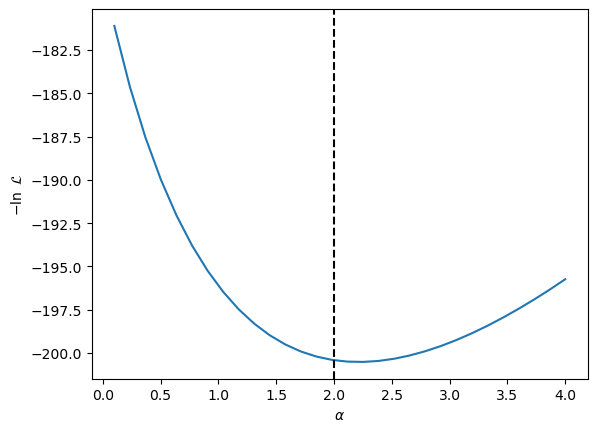

In [9]:
tmp_dist = np.linspace(0.1, 4.0, 30)
tmp_prob = np.zeros(len(tmp_dist))
for i in range(len(tmp_dist)):
    tmp_prob[i] = neg_ln_posterior(tmp_dist[i], dist_max, plx_obs, plx_err)
#     print(tmp_dist[i], tmp_prob[i])
plt.plot(tmp_dist, tmp_prob)


plt.axvline(2.0, color='k', linestyle='dashed')

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$-\ln\ \mathcal{L}$")

plt.show()

# Machine learning minimization

Using the exact same posterior function which we've previously calculated, we can run a minimizer to determine the most optimal value of $\alpha$ given our data set. The only thing required is a starting value. Here, we will supply the minimizer with the wrong starting value and see what it finds as the best-fit to the data. 

Minimizing...

Expected result: 2.0
Result: [2.214416]
Elapsed time: 1.3517913818359375 seconds


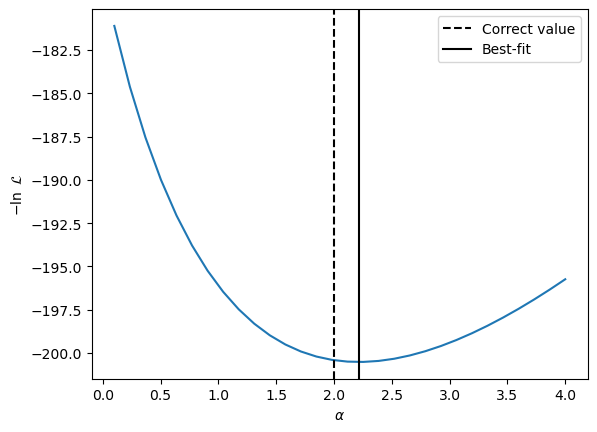

In [10]:
from scipy.optimize import minimize
import time

# First, plot the results from the previous simulation
plt.plot(tmp_dist, tmp_prob)


# We will give it the wrong starting value
p0 = 4.0

print("Minimizing...")
start = time.time()
res = minimize(neg_ln_posterior, p0, args=(dist_max, plx_obs, plx_err))
end = time.time()

print()
if res.success:
    print("Expected result: 2.0")
    print("Result:", res.x)
else:
    print("Optimization failed")
    
print("Elapsed time:", end-start, "seconds")


plt.axvline(2.0, color='k', linestyle='dashed', label='Correct value')

plt.axvline(res.x, color='k', label='Best-fit')

plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$-\ln\ \mathcal{L}$")
plt.show()

### Conclusions

Even when data seems to be reasonably distributed, prior distributions may lead to unexpected results. Please, please, please consider your priors! As long as you can write your prior distribution down, you have a generative model, and your likelihood function is well formed, you can calculate a posterior probability (ignoring the Bayesian evidence). Once having done so, you can solve for the result using a grid search (where you systematically test a range of values), some minimization technique (as was done above), or other methods which we will learn about in the afternoon.